# Stage 2: Event Classification

## Waveform Features
It is useful to compute amplitude, energy, and frequency features of each event waveform in real-time, and store them in some sort of "database" so these features can be exploited for automated event classification (e.g. machine learning), location (e.g. amplitude-source location), and quantification (e.g. Reduced Displacement, Magnitude).

We already stored some "whole waveform" features, such as peak amplitude and duration, and naively converted the median peak amplitude from the set of triggered channels to a sort of "uncalibrated magnitude". But now we want to break down each waveform into a series of small time windows and compute more features.

We will exploit the RSAM class here (class in the Object-Oriented sense) which is in lib/SAM.py (a "Python module"). The RSAM class is a convenient way of downsampling (raw) seismic data. The original RSAM system used 2.56s, 60s, and 600s. I prefer to use 2.56s for events, and 60s for continuous data. For each time window, the RSAM class computes the following features:

- mean amplitude
- median amplitude
- max amplitude
- std (same as rms after detrending) amplitude
- mean amplitude in "VT band"
- mean amplitude in "LP band"
- mean amplitude in "VLP band"
- base-2 logarithm of the ratio of VT to LP band amplitudes (frequency ratio ...)

These are all features can be quickly computed because they can be done in the time domain. (I also have a more advanced "Spectrograms" module which among other things, computes a wider array of features in the frequency domain).

<em>(Note, we can improve this by using correcting raw to velocity seismograms, and then computing VSAM instead of RSAM, to get corrected amplitude information, and also computing VSEM to get energy features too. But this tutorial focuses on frequency ratio for which RSAM works just as well...)</em>

## Frequency ratio
For this simple tutorial, we will break down each signal between the trigger ON and trigger OFF times into 2.56-s time windows, and compute the "Frequency Ratio", which is a base-2 logarithm of the amplitude ratio of the VT frequency band versus the LP frequency band:

\begin{align}
fratio & = log_{2} \frac {A_{VT}}{A_{LP}} \\
\end{align}

                                                                        (Rodgers et al., 2016)

We use the following definitions of the VT and LP bands:

<table border=1>
    <tr><td>Class</td><td>Frequency Band (Hz)</td></tr>
    <tr><td>LP</td><td>0.8 - 4.0</td></tr>
    <tr><td>VT</td><td>4.0 - 18.0</td></tr>
</table>

This means if the duration (trigger OFF - trigger ON time) of a signal is 25.6 s, and we use 6 channels, we get 60 separate measurements of frequency ratio. The time evolution of the signal is important in deciding if the signal is a hybrid, because a hybrid has a VT onset and an LP coda.

## Classification

Remember that MVO assigned (sub)classes are:
<table>
    <tr><th>subclass</th><th>description</th></tr>
    <tr><td>'t'</td><td>Volcano-tectonic earthquake ("VT")</td></tr>    
    <tr><td>'h'</td><td>Hybrid earthquake (VT onset, LP coda)</td></tr>
    <tr><td>'l'</td><td>Long-period earthquake ("LP")</td></tr>
    <tr><td>'r'</td><td>Rockfall signal. There is a continuum between dome-collapse-derived rockfalls and pyroclastic flows.</td></tr>    
    <tr><td>'e'</td><td>LP-rockfall (probably a pyroclastic flow)</td></tr> 
</table>


We will run a very simplistic (and unreliable!) event classifier from the vsmTools package. This uses frequency ratio and amplitude information (both from the RSAM object):

For each 2.56s time window, for each channel, get a vote based on:
<table>
    <tr><th>fratio</th><th>subclass</th></tr>
    <tr><th>> 0.0</th><th>VT ('t')</th></tr>    
    <tr><th>-1.0 to 0.0</th><th>Hybrid ('h')</th></tr>
    <tr><th>< -1.0</th><th>LP ('l')</th></tr>
</table>

For each channel, looking at patterns of amplitude and fratios (a linear regression performed for fratios):
<table>
    <tr><th>pattern</th><th>subclass</th></tr>
    <tr><td>amplitude peaks early</td><td>earthquake (VT, LP, hybrid)</td></tr>    
    <tr><td>amplitude peaks near middle</td><td>rockfall ('r')</td></tr>
    <tr><td>fratio falling</td><td>Hybrid ('h')</td></tr>
    <tr><td>fratio rising</td><td>LP-rockfall ('e')</td></tr>    
</table>
Patterns are weighted more heavily (in proportion to size of change).

Signal durations are also taken into account as there is a general increase from:

VT -> Hybrid -> LP ----> rockfall ----> LP-rockfall 

## Examples:
1. We compute the frequency ratios for 1 event.
2. We compute the frequency ratios for each event in the catalog.

We will use the catalog we just generated from 10 days of continuous MVO seismic data, and see how the frequency ratio changes before and after the large dome collapse that began at 02:00 UTC on 13th July 2003.

### Reload catalog

First, we will load the catalog from the previous notebook (this might take a few tens of seconds because it has to parse over 4000 events from the QuakeML file):


In [1]:
import os
import sys
import pandas as pd
import obspy
import warnings
warnings.filterwarnings("ignore") # turn off warnings about Miniseed file encoding (and anything else!)
sys.path.append('lib')
import vsmTools

DATA_DIR = os.path.join('data')
EVENTS_DIR = os.path.join(DATA_DIR, 'events')
CATALOG_DIR = os.path.join(DATA_DIR,'catalogs')

catObj = vsmTools.load_catalog(CATALOG_DIR,'catalog_MV_20030712')
print(catObj)

4314 Event(s) in Catalog:
2003-07-09T00:00:15.973333Z | None, None | 0.44 None
2003-07-09T00:10:52.493333Z | None, None | 0.93 None
...
2003-07-15T23:22:25.520000Z | None, None | 0.70 None
2003-07-15T23:49:44.840000Z | None, None | 0.25 None
To see all events call 'print(CatalogObject.__str__(print_all=True))'


### Convert catalog object to a pandas DataFrame
Again we convert the VolcanoSeismicCatalog object to a dataframe, since this is easy to work with:

In [2]:
catDF = catObj.to_dataframe()

## Example 1: Compute  the frequency ratio for 1 event

We are leveraging the RSAM class here, more on this later, it is just a convenient way to downsample data and compute some features.

datetime          2003-07-11 05:55:03.186667
magnitude                           0.384238
energy                              3.770139
latitude                                None
longitude                               None
depth                                   None
filename                     20030711T055503
duration                            9.333333
classification                          None
Name: 2200, dtype: object
2003-07-11T05:55:03.186667Z


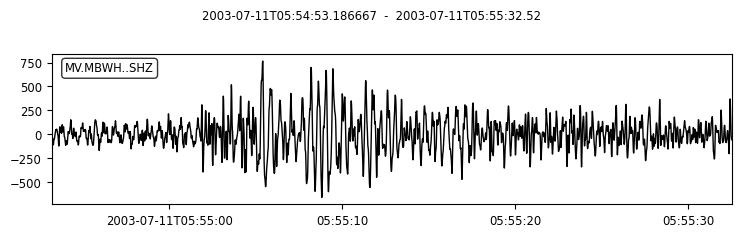

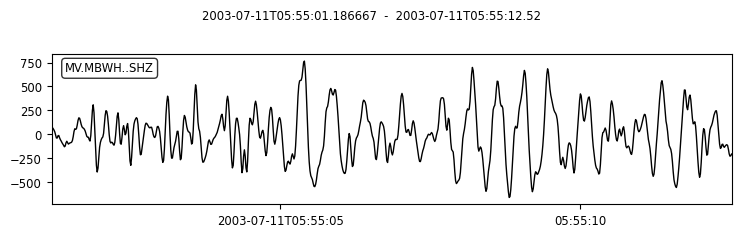

<Axes: xlabel='datetime', ylabel='Frequency Ratio'>

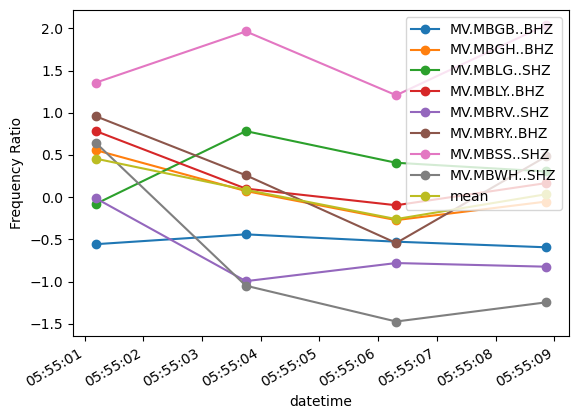

In [3]:
from SAM import RSAM
def compute_fratio(st, evtime, duration, plot_streams=False, sampling_interval=2.56):
    trigger_delay=2 # based on one hybrid, trigger seems to be delayed about 2-s
    for tr in st:
        tr.stats['units'] = 'Counts'
    st.detrend('linear')
    st.trim(starttime=evtime-trigger_delay, endtime=evtime+duration)
 
    # Generate an RSAM object
    rsamObj = RSAM(stream=st, sampling_interval=sampling_interval)
            
    dfratio = pd.DataFrame()
    for i, seed_id in enumerate(rsamObj.dataframes):
        df = rsamObj.dataframes[seed_id]
        if i==0:
            dfratio['datetime'] = [obspy.core.UTCDateTime(t).datetime for t in df['time']]
        dfratio[seed_id] = df['fratio']
    dfratio['mean'] = dfratio.mean(axis=1, numeric_only=True)
    #print(f"Average Frequency Ratio for whole event: {dfratio['mean'].mean():.1f}")

    return rsamObj, dfratio

SAMPLING_INTERVAL = 2.56

# read the 1000'th event in the catalog
eventIndex = 2200
row = catDF.iloc[eventIndex]
print(row)
this_trig = catObj.triggers[eventIndex]
evtime = obspy.UTCDateTime(row['datetime'])
print(evtime)

# load corresponding miniseed file
year = evtime.strftime('%Y')
month = evtime.strftime('%m')
duration = row['duration']
mseedfile = os.path.join(EVENTS_DIR, 'WAV', 'MV', year, month, row['filename'] + '.mseed')
st = obspy.read(mseedfile, 'MSEED')

# plot Stream (just final Trace)
st[-1].plot()

# now cut off the pretrig and posttrig windows - this is the actual waveform that triggered
st2 = st.copy().trim(starttime=evtime-2, endtime=evtime+row['duration'])
st2[-1].plot()

# compute and plot frequency ratio
rsamObj, dfratio = compute_fratio(st, evtime, duration, plot_streams=True, sampling_interval=SAMPLING_INTERVAL)
dfratio.plot(x='datetime', style='-o', ylabel='Frequency Ratio')

Note the duration of the event was only 9.3s so we only had 3 complete 2.56s windows (4 total). Longer events are more interesting for frequency ratio analysis! Nevertheless, we can see from the waveform it appears to a hybrid event (VT onset, LP coda). And if we run a far-too-simplistic classification function from the vsmTools package, we also get hybrid ('h') as the most likely answer:

In [4]:
from vsmTools import classify_event

subclass = classify_event(dfratio, rsamObj, this_trig, sampling_interval=SAMPLING_INTERVAL)
print(subclass)

h


## Example 2: Compute the frequency ratios and guess subclass for each event in the catalog

<b>Warning!</b> This part takes 4-5 minutes to run on my office Linux PC. This is why the code is set to load the frequency ratio dataframe from a Pickle file if that exists already. 

In [6]:
dfratioPickle=os.path.join(CATALOG_DIR,'dfratio_MV_20030712.pkl')

if os.path.isfile(dfratioPickle):
    dfratio_all = pd.read_pickle(dfratioPickle)
    catObj = vsmTools.load_catalog(CATALOG_DIR,'catalog_MV_20030712_with_subclasses')
else:
    # process events
    subclasses = []
    dfratio_all = None
    prevYmdh = '0000/00/00 00:00'

    for index, row in catDF.iterrows():
        evtime = obspy.UTCDateTime(row['datetime'])
        duration = row['duration']
        Ymdh = evtime.strftime('%Y/%m/%d %H:00')
        if Ymdh > prevYmdh:
            print(f'Processing {Ymdh} ...')
            prevYmdh = Ymdh
        mseedfile = os.path.join(EVENTS_DIR, 'WAV', 'MV', Ymdh[0:4], Ymdh[5:7], row['filename'] + '.mseed')    
        st = obspy.read(mseedfile, format='MSEED')
        rsamObj, dfratio = compute_fratio(st, evtime, duration, sampling_interval=SAMPLING_INTERVAL)

        this_trig = catObj.triggers[index]

        try: 
            subclass = classify_event(dfratio, rsamObj, this_trig, sampling_interval=SAMPLING_INTERVAL)
            subclasses.append(subclass)
        except:
            subclasses.append('n')
        #print(subclasses)
        
        if len(dfratio)==0:
            dfratio_all = dfratio
        else:
            dfratio_all = pd.concat([dfratio_all, dfratio])
    catObj.classifications = subclasses
    catObj.save(CATALOG_DIR,'catalog_MV_20030712_with_subclasses')
    dfratio_all.to_pickle(dfratioPickle)
catDF = catObj.to_dataframe()

In [7]:
for subclass in ['r', 'e', 'l', 'h', 't']:
    print(subclass, catObj.classifications.count(subclass))

r 2143
e 12
l 13
h 1842
t 304




 r


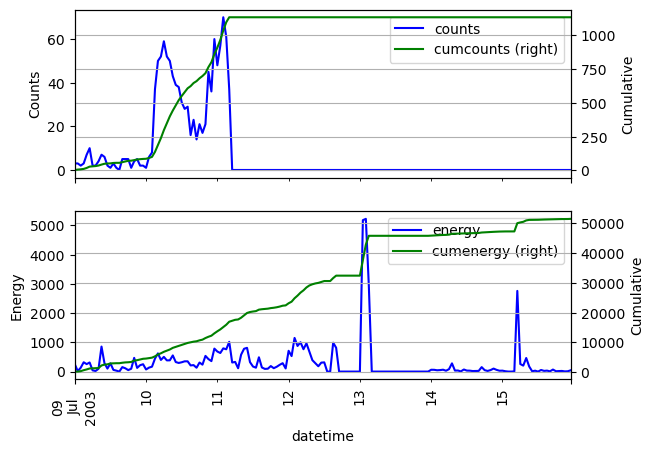



 e


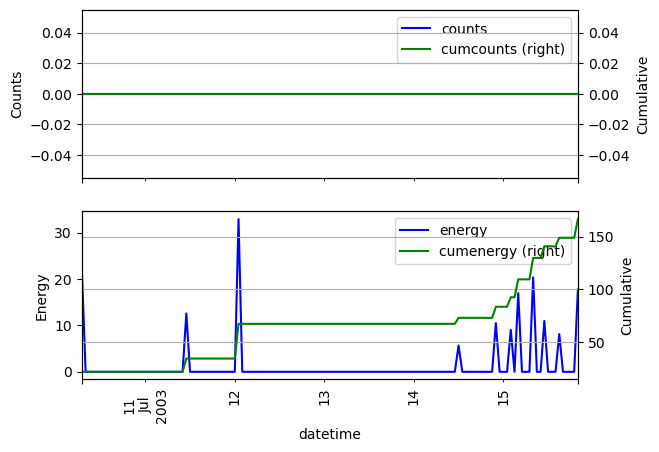



 l


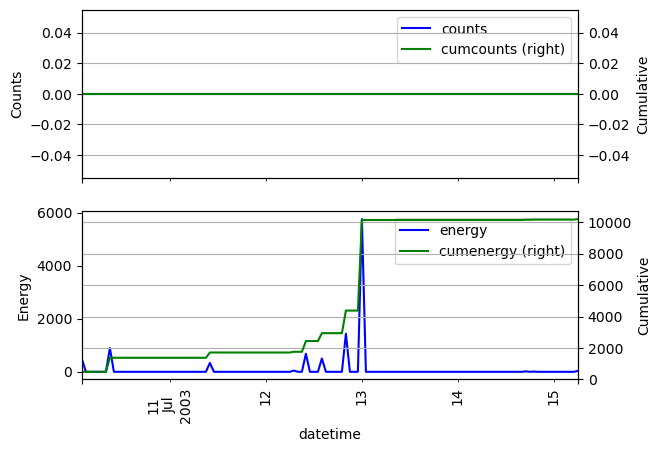



 h


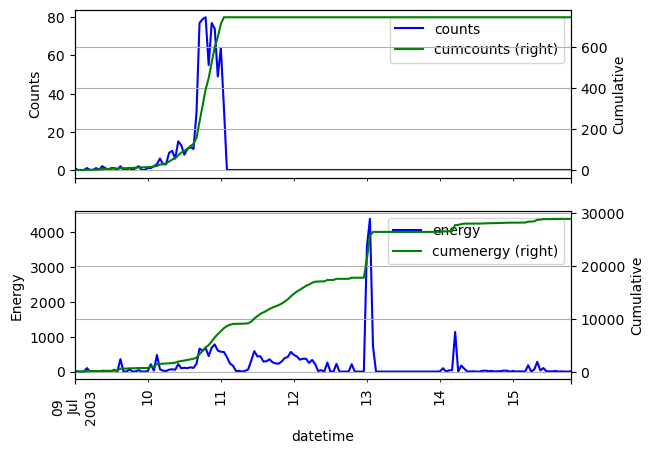



 t


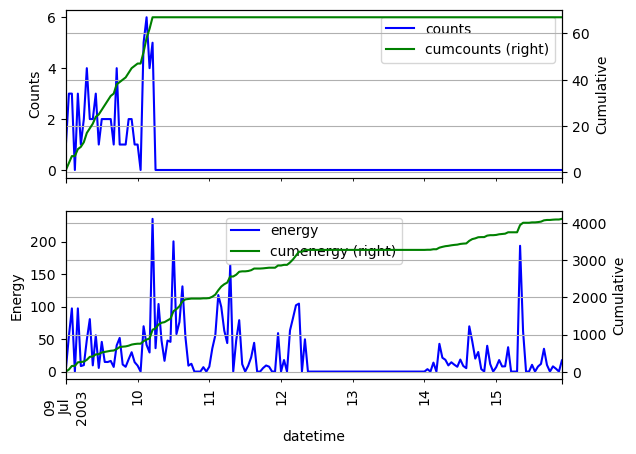

In [8]:
for subclass in ['r', 'e', 'l', 'h', 't']:
    mask = (catDF['classification'] == subclass)
    df = catDF.loc[mask]
    print('\n\n', subclass)
    vsmTools.plot_eventrate(df, binsize=pd.Timedelta(hours=1))

According to this simplistic classifier which uses frequency ratio and amplitude data (and trends in both), most of the events are 'r' (block and ash rockfalls -> pyroclastic flows) or 'h' (hybrid earthquakes). This makes sense because the drumbeats are a hybrid earthquake swarm related to dome growth, and we know the dome collapses too in a series of block and ash flows. 

## Plot frequency ratio and magnitude versus time

OK, remember in the presentation where we saw the drop in frequency ratio in the continuous data ~18 hours prior to the phreatic explosion at Whakaari? Well, <b>we see a similar result here in the event data!</b>

Index(['datetime', 'MV.MBGB..BHZ', 'MV.MBGH..BHZ', 'MV.MBLG..SHZ',
       'MV.MBLY..BHZ', 'MV.MBRV..SHZ', 'MV.MBRY..BHZ', 'MV.MBSS..SHZ',
       'MV.MBWH..SHZ', 'mean'],
      dtype='object')


[12241.650550115735,
 12249.342514853397,
 12241.650550115735,
 12249.342514853397]

<Figure size 640x480 with 0 Axes>

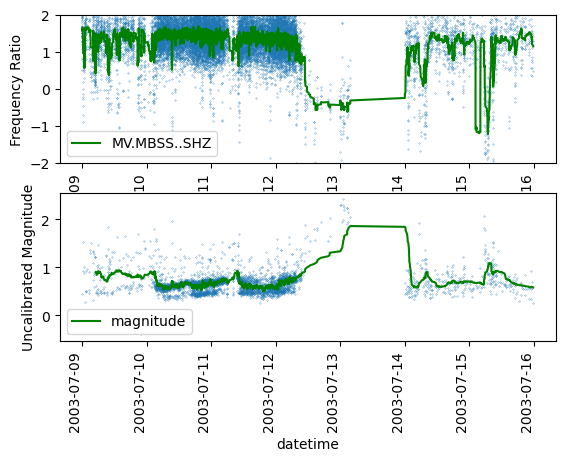

In [9]:
import matplotlib.pyplot as plt
dfratio_rolling = dfratio_all.copy()
print(dfratio_all.columns)
fig = plt.figure()
fig, ax = plt.subplots(2,1)
col = 'MV.MBSS..SHZ'
dfratio_rolling.plot.scatter(ax=ax[0], x='datetime', y=col, s=0.05, rot=90, ylabel='Frequency Ratio')
dfratio_rolling[col] = dfratio_rolling[col].rolling(30).mean()
dfratio_rolling.plot.line(ax=ax[0], x='datetime', y=col, style='g', rot=90, ylabel='Frequency Ratio')
ax[0].set_ylim([-2.0, 2.0])

catDF.plot.scatter(ax=ax[1], x='datetime', y='magnitude', s=0.05, rot=90, ylabel='Uncalibrated Magnitude')
catDF_rolling = catDF.copy()
catDF_rolling['magnitude'] = catDF_rolling['magnitude'].rolling(30).mean()
catDF_rolling.plot.line(ax=ax[1], x='datetime', y='magnitude', style='g', rot=90)
plt.setp(ax, xlim=ax[1].get_xlim())

We observe that from around 2003/07/12 08:00, as event magnitudes increase, frequency ratios drop. 

That was using the 'mean' frequency ratio across the seismic network. We can also examine individual channels:


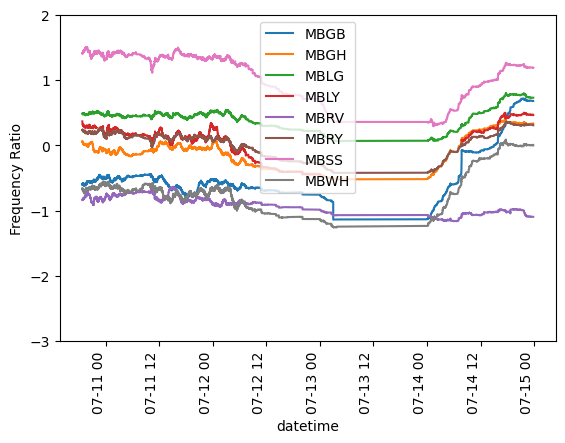

In [10]:
from datetime import datetime 
dfratio_subset= dfratio_all.loc[(dfratio_all['datetime'] >= datetime(2003,7,10, 18, 0, 0)) & (dfratio_all['datetime'] <= datetime(2003,7,15))]
dfratio_rolling = dfratio_subset.copy()

fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
for col in dfratio_all.columns:
    if col[0:2]=='MV':
        network, station, location, channel = col.split('.')
        dfratio_rolling[col] = dfratio_rolling[col].rolling(300).mean()
        dfratio_rolling.plot.line(ax=ax1, x='datetime', y=col, rot=90, ylabel='Frequency Ratio', label=station)
        ax1.set_ylim([-3.0, 2.0])

All show a similar pattern, but we also see different biases, likely due to local site effects. Also, we have not (yet) instrument corrected the data, but we have only two types of instrument, so probably that is not the main reason for different behaviour.